<a id="section-one"></a>
# **I-Notebook Objective**:

I used this **competition dataset** to implement the **STAM** model (**Spatiotemporal Attention Mechanism** for Multivariate Time Series) : A **cutting-edge deep leaning model (2020) for time series**.  

The link of the [arxiv paper](https://arxiv.org/abs/2008.04882).  

- To break down and explain the model, I created a number of instructive **illustrations**.
- I used this competition dataset to create an original and **simplified implementation** of the STAM model (using **TensorFlow & Keras**) and I trained the model using **TPU accelerator**.
- In the last paragraph "VVI- Discussion and Suggestions for using STAM Model on the competition's test dataset", I give **hints** and **tips** on how to use the **STAM model** for **inference** (on the **test dataset**).

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from sklearn import preprocessing

2022-05-04 09:22:58.474932: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-05-04 09:22:58.475061: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<a id="section-two"></a>
# **II-Loading Data**:


In [2]:
train_path = '../input/smart-homes-temperature-time-series-forecasting/train.csv'
test_path = '../input/smart-homes-temperature-time-series-forecasting/test.csv'

In [3]:
df = pd.read_csv(train_path)
df.head()

,Id,Date,Time,CO2_(dinning-room),CO2_room,Relative_humidity_(dinning-room),Relative_humidity_room,Lighting_(dinning-room),Lighting_room,Meteo_Rain,Meteo_Sun_dusk,Meteo_Wind,Meteo_Sun_light_in_west_facade,Meteo_Sun_light_in_east_facade,Meteo_Sun_light_in_south_facade,Meteo_Sun_irradiance,Outdoor_relative_humidity_Sensor,Day_of_the_week,Indoor_temperature_room
0,0,13/03/2012,11:45,216.560,221.920,39.9125,42.4150,81.6650,113.520,0.0,623.360,1.42625,9690.24,12604.20,95436.8,758.880,48.3750,2.0,17.8275
1,1,13/03/2012,12:00,219.947,220.363,39.9267,42.2453,81.7413,113.605,0.0,623.211,1.59200,11022.00,10787.20,95436.8,762.069,47.8080,2.0,18.1207
2,2,13/03/2012,12:15,219.403,218.933,39.7720,42.2267,81.4240,113.600,0.0,622.656,1.89133,13960.50,9669.63,95398.6,766.251,47.4320,2.0,18.4367
3,3,13/03/2012,12:30,218.613,217.045,39.7760,42.0987,81.5013,113.344,0.0,622.571,1.82800,18511.20,9648.13,95360.3,766.037,47.0240,2.0,18.7513
4,4,13/03/2012,12:45,217.714,216.080,39.7757,42.0686,81.4657,113.034,0.0,622.400,2.36071,26349.00,9208.32,95354.9,762.743,45.4743,2.0,19.0414


In [4]:
df.drop(['Id','Date','Time','Day_of_the_week'],axis=1,inplace=True)

In [5]:
df.dtypes

CO2_(dinning-room)                  float64
CO2_room                            float64
Relative_humidity_(dinning-room)    float64
Relative_humidity_room              float64
Lighting_(dinning-room)             float64
Lighting_room                       float64
Meteo_Rain                          float64
Meteo_Sun_dusk                      float64
Meteo_Wind                          float64
Meteo_Sun_light_in_west_facade      float64
Meteo_Sun_light_in_east_facade      float64
Meteo_Sun_light_in_south_facade     float64
Meteo_Sun_irradiance                float64
Outdoor_relative_humidity_Sensor    float64
Indoor_temperature_room             float64
dtype: object

In [6]:
df = df.astype(dtype="float32")
df.dtypes

CO2_(dinning-room)                  float32
CO2_room                            float32
Relative_humidity_(dinning-room)    float32
Relative_humidity_room              float32
Lighting_(dinning-room)             float32
Lighting_room                       float32
Meteo_Rain                          float32
Meteo_Sun_dusk                      float32
Meteo_Wind                          float32
Meteo_Sun_light_in_west_facade      float32
Meteo_Sun_light_in_east_facade      float32
Meteo_Sun_light_in_south_facade     float32
Meteo_Sun_irradiance                float32
Outdoor_relative_humidity_Sensor    float32
Indoor_temperature_room             float32
dtype: object

<a id="section-three"></a>
# **III-Splitting Data & Visualizations:**


In [7]:
percentage = 0.8
splitting_time = int(len(df) * percentage)

train_x = np.array(df.values[:splitting_time],dtype=np.float32)
val_x = np.array(df.values[splitting_time:],dtype=np.float32)

print("train dataset size : %d" %len(train_x))
print("validation dataset size : %d" %len(val_x))

train dataset size : 2211
validation dataset size : 553


In [8]:
# Construction of the series

train_x = tf.convert_to_tensor(train_x)
test_x = tf.convert_to_tensor(val_x)

scaler = preprocessing.MinMaxScaler()
scaler.fit(train_x)

train_x_norm = scaler.transform(train_x)
val_x_norm = scaler.transform(val_x)

2022-05-04 09:23:05.758208: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-04 09:23:05.761336: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-05-04 09:23:05.761380: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-04 09:23:05.761407: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (38b940e93784): /proc/driver/nvidia/version does not exist
2022-05-04 09:23:05.763770: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

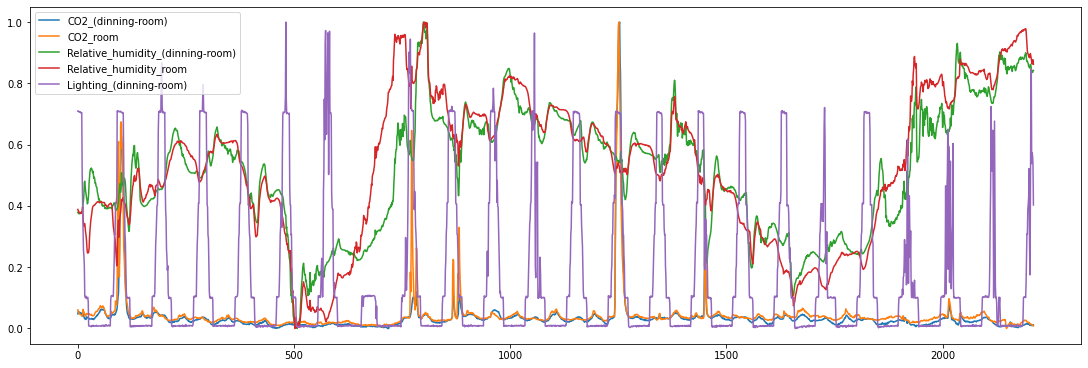

In [9]:
# Displaying some scaled series 
cols = list(df.columns)

fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))
for i in range(5):
  ax.plot(df.index[:splitting_time].values,train_x_norm[:,i], label= cols[i])
ax.legend()
plt.show()

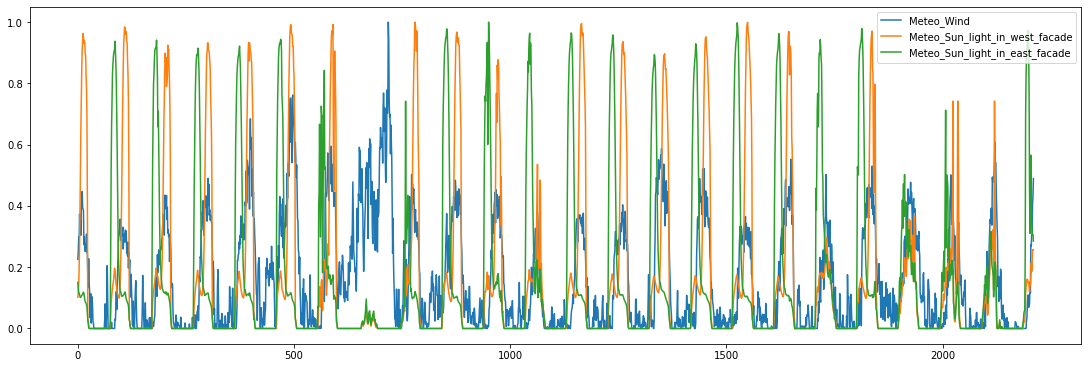

In [10]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))
for i in range(8,11):
  ax.plot(df.index[:splitting_time].values,train_x_norm[:,i], label= cols[i])
ax.legend()
plt.show()

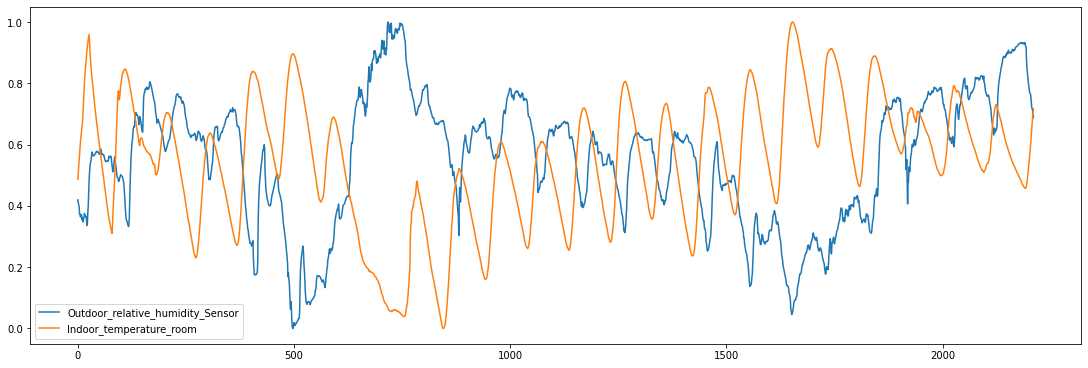

In [11]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))
for i in [13,14]:
  ax.plot(df.index[:splitting_time].values,train_x_norm[:,i], label= cols[i])
ax.legend()
plt.show()

<a id="section-four"></a>
# **IV-Datasets creation:**

- This part is a **data preprocessing step** that allows the data to **be adapted to the STAM model** (for more details, see the paper: **paragraph 3-1 Notations and Problem Formulation** [here](https://arxiv.org/pdf/2008.04882.pdf)
- Within the function below "**prepare_dataset_XY**" I refer to '**exogenous series**' as all of the dataset's series except the target one.
- Following the function, I provide a **practical numeric example**, breaking down the function to help you understand **what form** of data you'll need for the **STAM model** (as indicated in paragraph 3-1 of the paper in equations mathematics)

In [12]:
def prepare_dataset_XY(seriesx, seriesy, len_seq, len_out, batch_size,shift):
  '''
  A function for creating a tf.dataset from time series data as follows:
  dataset : {X,Y}
  X = {((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),(X3_1,X3_2,...,X3_T)),
       (Y1,Y2,...,YT)}
  Y = YT+1
  seriesx-- Exogenous series, shape: (Tx, number_of_exogenous_series) with Tx: length of the time series
  seriesy-- Target series, shape: (Tx, 1)
  len_seq-- Sequence length: integer
  len_out-- Length of the predicted sequence (output): integer
  shift-- The window offset: integer
  batch_size-- Size of the batch: integer

  '''
  # Exogenous series
  # ((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),(X3_1,X3_2,...,X3_T),....)
  dataset_x = tf.data.Dataset.from_tensor_slices(seriesx)
  dataset_x = dataset_x.window(len_seq+len_out, shift = shift, drop_remainder=True)
  dataset_x = dataset_x.flat_map(lambda x: x.batch(len_seq+len_out))
  dataset_x = dataset_x.map(lambda x: x[0:len_seq][:,:]) # shape:[[ ]]
  dataset_x = dataset_x.batch(batch_size, drop_remainder=True).prefetch(1) # shape: [[[]]] (adding the batch_size)

  # The target series
  # (Y1,Y2,...,YT)
  dataset_y = tf.data.Dataset.from_tensor_slices(seriesy)
  dataset_y = dataset_y.window(len_seq+len_out, shift = shift, drop_remainder=True)
  dataset_y = dataset_y.flat_map(lambda x: x.batch(len_seq+len_out))
  dataset_y = dataset_y.map(lambda x: x[0:len_seq][:,:]) 
  dataset_y = dataset_y.batch(batch_size, drop_remainder=True).prefetch(1)

  # Y = YT+1 (the values to predict)
  dataset_ypred = tf.data.Dataset.from_tensor_slices(seriesy)
  dataset_ypred = dataset_ypred.window(len_seq+len_out+1, shift=shift, drop_remainder=True)
  dataset_ypred = dataset_ypred.flat_map(lambda x: x.batch(len_seq+len_out+1))
  dataset_ypred = dataset_ypred.map(lambda x: (x[0:len_seq+1][-len_out:,:]))
  dataset_ypred = dataset_ypred.batch(batch_size, drop_remainder=True).prefetch(1)

  dataset = tf.data.Dataset.zip((dataset_x, dataset_y))
  dataset = tf.data.Dataset.zip((dataset, dataset_ypred))
  return dataset

- **Practical example, breaking down the "prepare_dataset_XY" function**


In [13]:

X1 = np.linspace(1,100,100) # 3 exogenous series
X2 = np.linspace(101,200,100)
X3 = np.linspace(201,300,100)
Y = np.linspace(301,400,100) # target series

X1 = tf.expand_dims(X1,-1)
X2 = tf.expand_dims(X2,-1)
X3 = tf.expand_dims(X3,-1)
Y = tf.expand_dims(Y,-1)

series_x = tf.concat([X1,X2,X3], axis=1)
series_y = Y
print(series_x.shape)
print(series_y.shape)

(100, 3)
(100, 1)


In [14]:
len_seq = 10
len_out = 1
shift = 1
batch_size = 1

dataset_example = prepare_dataset_XY(series_x, series_y, len_seq, len_out, batch_size,shift)

for element in dataset_example.take(1):
  print("Exogenous series: ")
  print(element[0][0])
  print("----------------------")
  print("Target series: ")
  print(element[0][1])
  print("======================")
  print("Value to predict: ")
  print(element[1])


Exogenous series: 
tf.Tensor(
[[[  1. 101. 201.]
  [  2. 102. 202.]
  [  3. 103. 203.]
  [  4. 104. 204.]
  [  5. 105. 205.]
  [  6. 106. 206.]
  [  7. 107. 207.]
  [  8. 108. 208.]
  [  9. 109. 209.]
  [ 10. 110. 210.]]], shape=(1, 10, 3), dtype=float64)
----------------------
Target series: 
tf.Tensor(
[[[301.]
  [302.]
  [303.]
  [304.]
  [305.]
  [306.]
  [307.]
  [308.]
  [309.]
  [310.]]], shape=(1, 10, 1), dtype=float64)
Value to predict: 
tf.Tensor([[[311.]]], shape=(1, 1, 1), dtype=float64)


2022-05-04 09:23:08.860730: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-04 09:23:08.866109: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


- **Competition datasets creation using "prepare_dataset_XY" function**

In [15]:
# The characteristics of the dataset I want to create
batch_size = 128
len_seq = 20
len_out = 1
shift=1

# Dataset creation
dataset = prepare_dataset_XY(train_x_norm[:,0:-1], train_x_norm[:,-1:], len_seq, len_out, batch_size, shift)
dataset_val = prepare_dataset_XY(val_x_norm[:,0:-1], val_x_norm[:,-1:], len_seq, len_out, batch_size, shift)

In [16]:
# Number of batches (train dataset)
print(len(list(dataset.as_numpy_iterator())))

print(("---------------"))
for element in dataset.take(1):
  print(element[0][0].shape)
  print(element[0][1].shape)
  print(element[1].shape)

17
---------------
(128, 20, 14)
(128, 20, 1)
(128, 1, 1)


In [17]:
# Number of batches (validation dataset)

print(len(list(dataset_val.as_numpy_iterator())))
print(("---------------"))
for element in dataset.take(1):
  print(element[0][0].shape)
  print(element[0][1].shape)
  print(element[1].shape)

4
---------------
(128, 20, 14)
(128, 20, 1)
(128, 1, 1)


<a id="section-five"></a>
# **V-Datasets preparation:**

- **Training Dataset**

In [18]:
X1 = []
X2 = []

# Extracting x and y from the dataset
x,y = tuple(zip(*dataset))  #x: 17x((BS,20,16),(BS,20,1)) with BS refers to Batch Size
                           #y: 17x(BS,1,1)
for i in range(len(x)):
  X1.append(x[i][0])
  X2.append(x[i][1]) 

X1 = np.asarray(X1, dtype = np.float32) # (17,BS,20,16)
X2 = np.asarray(X2, dtype = np.float32) # (17,BS,20,1)
y =  np.asarray(y, dtype= np.float32)   # (17,BS,1,1)

# Reshaping them
X1 = np.reshape(X1,(X1.shape[0]*X1.shape[1], X1.shape[2], X1.shape[3])) # (17,BS,20,16) --> (17xBS,20,16)
X2 = np.reshape(X2,(X2.shape[0]*X2.shape[1], X2.shape[2], X2.shape[3])) # (17,BS,20,1)  --> (17xBS,20,1)

x_train = [X1,X2]
y_train = np.reshape(y,(y.shape[0]*y.shape[1], y.shape[2], y.shape[3])) # (17,BS,1,1) --> (17xBS,1,1)

print(x_train[0].shape)
print(x_train[1].shape)
print(y_train.shape)

(2176, 20, 14)
(2176, 20, 1)
(2176, 1, 1)


- **Validation dataset**

In [19]:
# Extracting x and y from the validation dataset
X1 =[]
X2 =[]
x,y = tuple(zip(*dataset_val)) 
        
for i in range(len(x)):
  X1.append(x[i][0])
  X2.append(x[i][1])

X1 = np.asarray(X1,dtype=np.float32)
X2 = np.asarray(X2, dtype = np.float32)
y = np.asarray(y, dtype= np.float32)

# Reshaping them
X1 = np.reshape(X1,(X1.shape[0]*X1.shape[1], X1.shape[2], X1.shape[3]))
X2 = np.reshape(X2,(X2.shape[0]*X2.shape[1], X2.shape[2], X2.shape[3]))

x_val = [X1,X2]
y_val = np.reshape(y,(y.shape[0]*y.shape[1], y.shape[2], y.shape[3]))

print(x_val[0].shape)
print(x_val[1].shape)
print(y_val.shape)

(512, 20, 14)
(512, 20, 1)
(512, 1, 1)


<a id="section-six"></a>
# **VI-Implementation of the STAM (Spatiotemporal Attention Mechanism for Multivariate Time Series) Model:**

**Reminder:**  
The STAM model (Spatiotemporal Attention Mechanism for Multivariate Time Series model) is a cutting-edge deep leaning model for time series (2020).
The link of the [arxiv paper.](https://arxiv.org/abs/2008.04882)

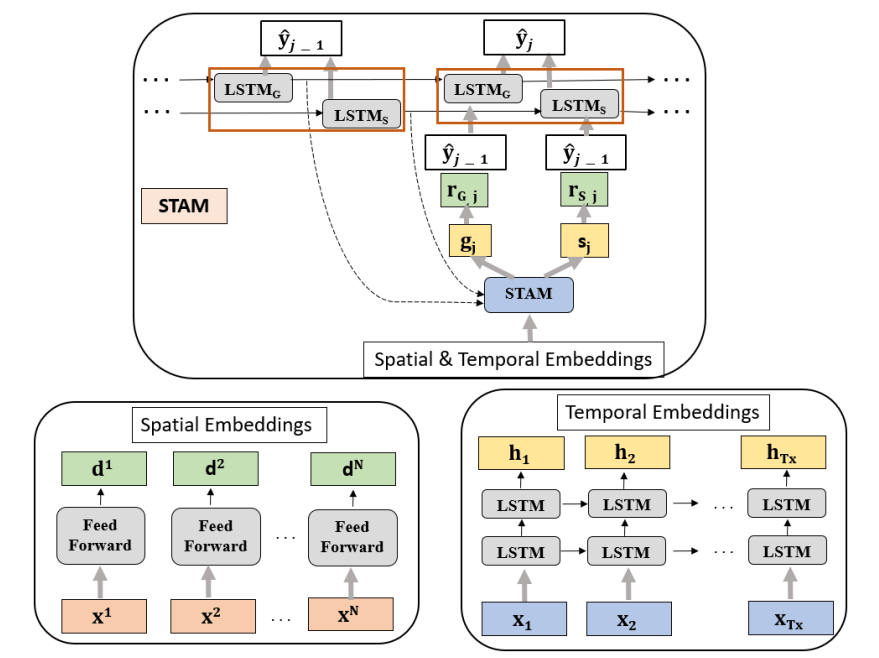

#### **1. Creation of the Spatial Embeddings Layer**


In [20]:
class CreationSpatialEmbeddings(tf.keras.layers.Layer):
    def __init__(self, dim_emb_space):
        self.dim_emb_space = dim_emb_space
        super().__init__()
        
    def build(self,input_shape):
        dense_layers = []
        input_dense_layers = []
        
        # Creation of the input for the N dense layers
        # input_shape = (BS,Tx,N), with BS= Batch_Size
        for i in range(input_shape[2]):
            input_dense_layers.append(tf.keras.Input(shape=(input_shape[1])))   #input_dense_layers: N*(BS,Tx)
            
        # Creation of the N dense layers
        for i in range(input_shape[2]):
            dense_layer = tf.keras.layers.Dense(units=self.dim_emb_space)(input_dense_layers[i]) # (BS, dim_emb_sapce)
            dense_layers.append(dense_layer) # N*(BS,dim_emb_space)
        
        # Creation of the output of the N dense layers
        out = tf.convert_to_tensor(dense_layers) # (N,BS,dim_emb_sapce)
        out = tf.transpose(out,perm=[1,0,2]) # (BS,N,dim_emb_sapce)/this shape for the Encoder(that will use keras TimeDistributed)
        
        # Creation of the Global Model
        self.Dense_Embeddings = tf.keras.Model(inputs=input_dense_layers, outputs=out)
        super().build(input_shape)
        
    # Inputs :
    # input is the Exogenous series & Target series : (BS,Tx,N)
    # Outputs :
    # spatial_embeddings are the Spatial Embeddings : (BS,N,dim_emb_space)
    def call(self, input):
        input_list = tf.unstack(input,axis=2)   # N*(BS,Tx), to have the same shape of the model input, above
        spatial_embeddings = self.Dense_Embeddings(input_list)    # (BS,N,dim_emb_space)
        return spatial_embeddings

#### **2. Creation of the Temporal Embeddings Layer**

In [21]:
class CreationTemporalEmbeddings(tf.keras.layers.Layer):
    def __init__(self, dim_emb_temp):
        self.dim_emb_temp = dim_emb_temp
        super().__init__()
    
    def build(self,input_shape):
        self.layer_lstm1 = tf.keras.layers.LSTM(units=self.dim_emb_temp, return_sequences=True)
        self.layer_lstm2 = tf.keras.layers.LSTM(units=self.dim_emb_temp, return_sequences=True)
        super().build(input_shape) 
        
    # Inputs :
    # input is Exogenous series & Target series  : (BS,Tx,N)
    # Outputs :
    # out_lstm are the Temporal Embeddings : (BS,Tx,dim_emb_temp)
    def call(self, input):
        out_lstm = self.layer_lstm1(input)      #(BS,Tx,dim_emb_temp)
        out_lstm = self.layer_lstm2(out_lstm)   #(BS,Tx,dim_emb_temp)
        return out_lstm

#### **3. Creation of the Spatial Attention layer**

Before creating the Spatial Attention layer, I depicted this layer **schematically** at **T=1**  

**Note**
- **BS** refers to  Batch Size    
- I mean by **T = 1**, the time of the **first prediction** that will be made. This time comes **just after** the **window size (len_seq)** that was determined during the creation of the datasets.

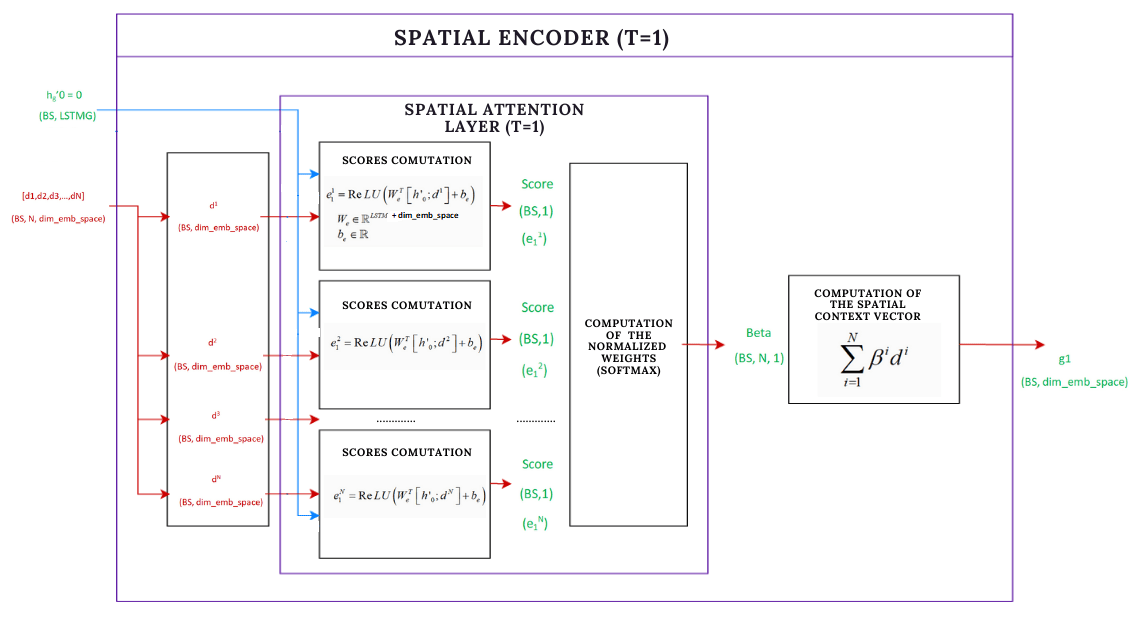

- I start by creating the **SCORES COMPUTATION** function for the **SPATIAL ENCODER** (See illustration above) 
- Then, **this function** is called by the **SPATIAL ATTENTION LAYER** using the **TimeDistributed method of Keras**.

In [22]:
class BlocScoresComputation_SpatialEncoder(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        
    def build(self, input_shape):
        self.DenseLayerScoresEncSpatial = tf.keras.layers.Dense(units=1,activation="relu")
        super().build(input_shape)
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], 1) # output_shape = (BS,1)
    
    # hidd_state is the hidden_state : (BS,#LSTMG)
    # I didn't include it as a parameter in call function below,because I won't be able to use this bloc later in Time Distributed 
    def SetStates(self,hidd_state):
        self.hidd_state = hidd_state
    
    # Inputs:
    # embeddings are the Spatial_Embeddings :(BS, dim_emb_space)
    # Outputs:
    # score : (BS,1)
    
    def call(self, spatial_embeddings):
        embeddings = tf.concat([spatial_embeddings, self.hidd_state],axis=1)  #(BS, dim_emb_sapce+LSTMG)
        score = self.DenseLayerScoresEncSpatial(embeddings)                   #(BS,1)
        return score

In [23]:
class SpatialAttention_SpatialEncoder(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()  
        
    def build(self,input_shape):
        self.layer_ScoresComputation_SpatialEncoder = BlocScoresComputation_SpatialEncoder()
        super().build(input_shape)
    
    # Inputs :
    # input is the Spatial Embeddings : (BS, N, dim_emb_sapce)
    # hid_state : Hidden state of the Spatial Decoder : (BS, LSTMG)
    
    # Outputs :
    # g is the Spatial Context Vector : (BS, dim_emb_space)
    
    
    def call(self, input,  hid_state):
        # Scores computation (in //)
        self.layer_ScoresComputation_SpatialEncoder.SetStates(hid_state) 
        beta = tf.keras.layers.TimeDistributed(
        self.layer_ScoresComputation_SpatialEncoder)(input)  # (BS, dim_emb_space) sent N times in //
                                                             # returns (BS,N,1)
        # Scores Nomalization
        beta = tf.keras.activations.softmax(beta,axis=1)     # (BS,N,1)
        
        # Spatial Context Vector computation
        g = tf.multiply(input, beta)    # (BS,N,dim_emb_space) x (BS,N,1) = (BS,N,dim_emb_space)
        g = K.sum(g, axis=1)            # (BS,dim_emb_space)
        return g


#### **4. Creation of the Temporal Attention Layer**

Before creating the Temporal Attention Layer I depicted this layer **schematically** at **T=1**   
**Note**
- **BS** = Batch Size -   
- I mean by **T = 1**, the time of the **first prediction** that will be made. This time comes **just after** the **window size(len_seq)** that was determined during the creation of the datasets.

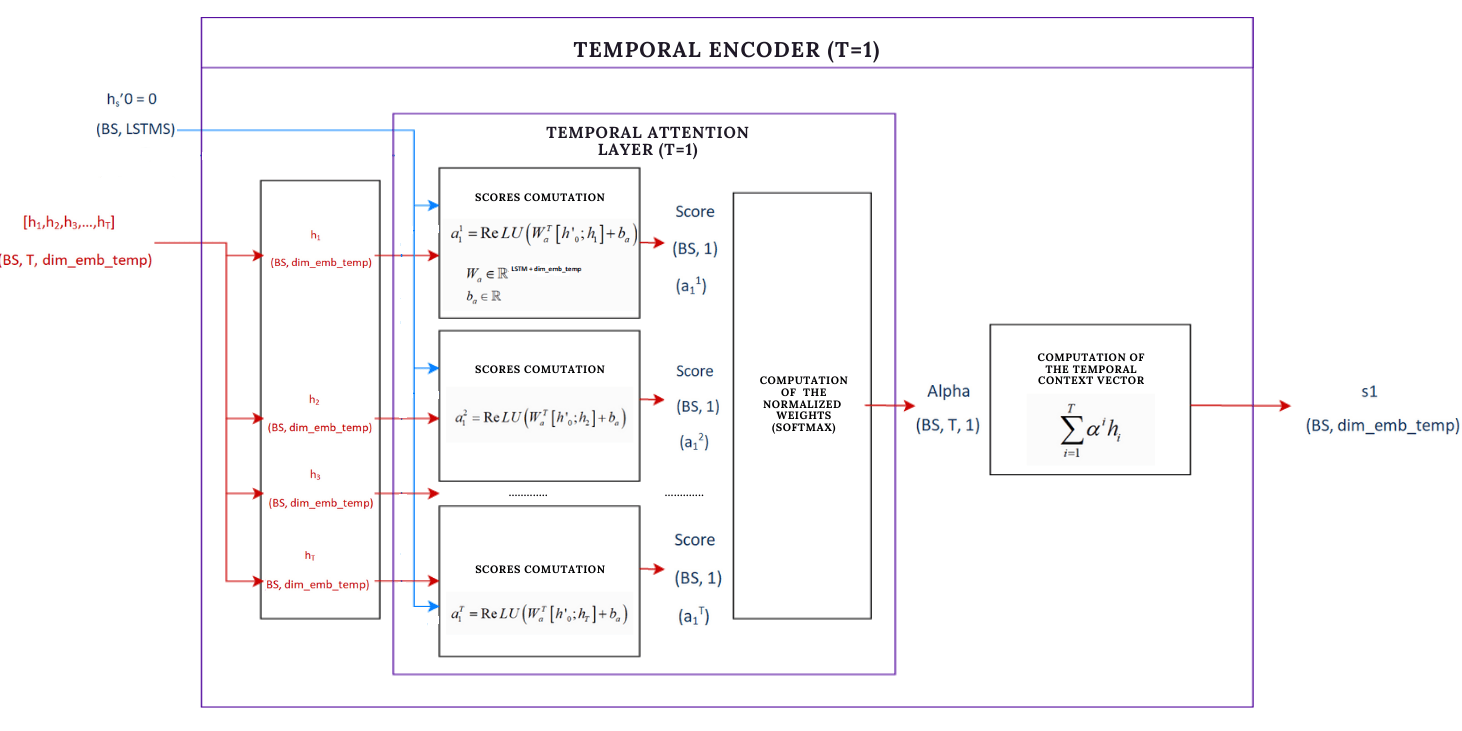

- I start by creating the **SCORES COMPUTATION** function for the **TEMPORAL ENCODER**.(See illustration above) 
- Then, **this function** is called by the **TEMPORAL ATTENTION LAYER** using the **TimeDistributed method of Keras**.

In [24]:
class BlocScoresComputation_TemporalEncoder(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        
    def build(self, input_shape):
        self.DenseLayerScoresEncTemporal = tf.keras.layers.Dense(units=1,activation="relu")
        super().build(input_shape)
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], 1) # output_shape = (BS,1)
        
    # hidd_state is the hidden_state : (BS,#LSTMS)
    # I didn't include it as a parameter in call function below,because I won't be able to use this bloc later in Time Distributed 
    
    def SetStates(self,hidd_state):
        self.hidd_state = hidd_state
    
    # Inputs:
    # temporal_embeddings :(BS, dim_emb_temp)
    # Outputs
    # score : (BS,1)
    
    def call(self, temporal_embeddings):
        embeddings = tf.concat([temporal_embeddings, self.hidd_state],axis=1)  #(BS, dim_emb_temp+LSTMS)
        score = self.DenseLayerScoresEncTemporal(embeddings)                   #(BS,1)
        return score

In [25]:
class TemporalAttention_TemporalEncoder(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
    
    def build(self,input_shape):
        self.layer_ScoresComputation_TemporalEncoder = BlocScoresComputation_TemporalEncoder()
        super().build(input_shape)
    
    # Inputs :
    # input is the Temporal Embeddings : (BS, Tx, dim_emb_temp)
    # hid_state : Hidden state of the Temporal Decoder : (BS, LSTMS)
    # Outputs :
    # s is the Temporal Context Vector : (BS, dim_emb_temp)
    
    def call(self, input,  hid_state):
        # Scores computation (in //)
        self.layer_ScoresComputation_TemporalEncoder.SetStates(hid_state)
        alpha = tf.keras.layers.TimeDistributed(
        self.layer_ScoresComputation_TemporalEncoder)(input) # (BS, dim_emb_temp) sent Tx times in //
                                                             # returns (BS,Tx,1) 
        # Scores Nomalization
        alpha = tf.keras.activations.softmax(alpha,axis=1)       # (BS,Tx,1)
        
        # Temporal Context Vector computation
        s = tf.multiply(input, alpha)    # (BS,Tx,dim_emb_temp) x (BS,Tx,1) = (BS,Tx,dim_emb_temp)
        s = K.sum(s, axis=1)             # (BS,dim_emb_temp)
        return s

#### **5. Creation of the Spatial Decoder Layer**

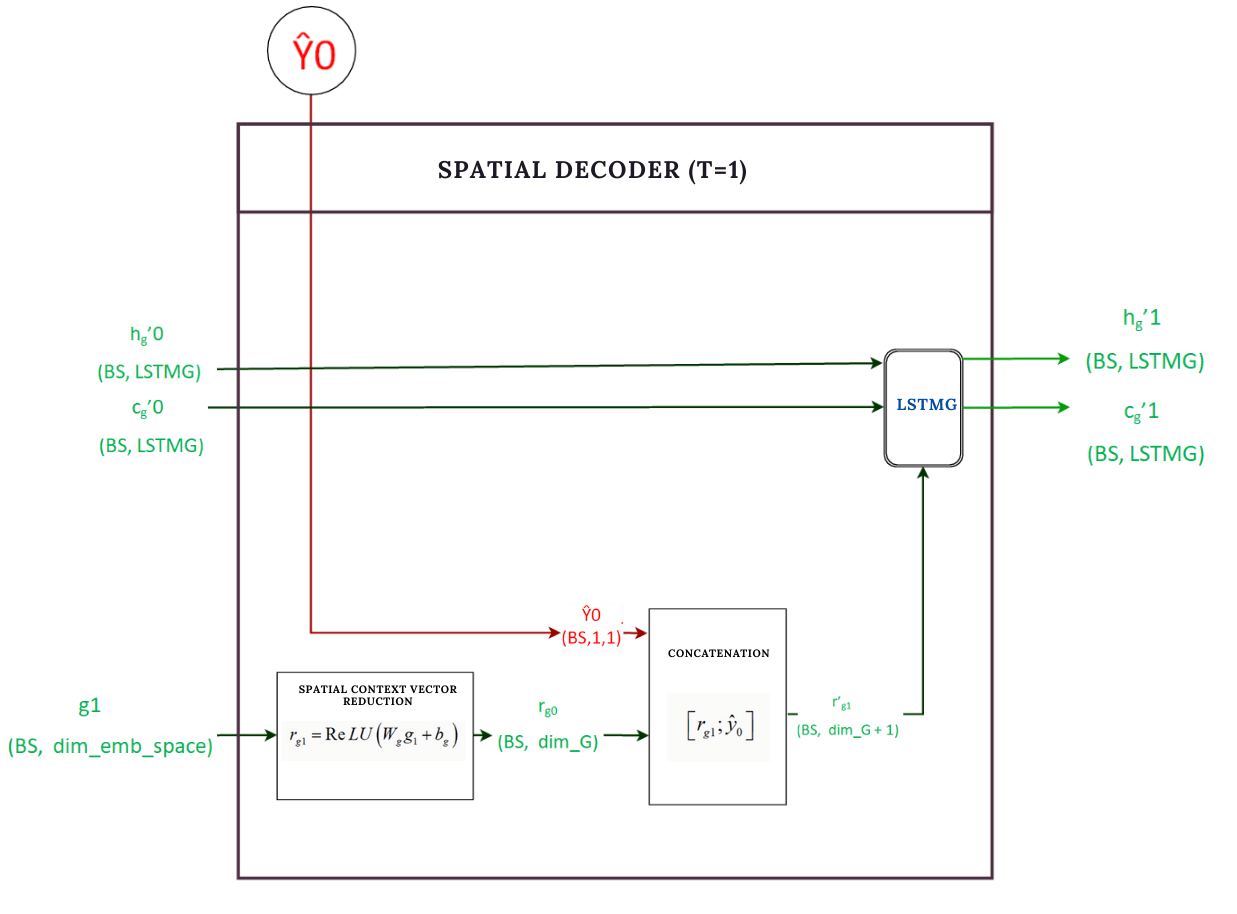

In [26]:
class SpatialDecoder(tf.keras.layers.Layer):
    def __init__(self, dim_LSTMG,dim_G,regul,drop):
        self.drop = drop
        self.regul = regul
        self.dim_LSTMG = dim_LSTMG          # Dimension of the hidden states
        self.dim_G = dim_G                  # Reduced dimension of the spatial context vector
        super().__init__() 
        
    def build(self,input_shape):
        self.SpatialReducedLayer = tf.keras.layers.Dense(units=self.dim_G,activation="relu")
        self.LayerLSTMG = tf.keras.layers.LSTM(units=self.dim_LSTMG,return_state=True,kernel_regularizer=tf.keras.regularizers.l2(self.regul),
                                           dropout=self.drop,recurrent_dropout=self.drop,name="LSTM_SpatialDecoder")
        super().build(input_shape)
    # inputs :
    # vc_spatial : Spatial Context Vector : (BS,dim_emb_space)
    # hid_state_1 : Hidden state of the Spatial Decoder (t-1) : (BS,LSTMG)
    # cell_state_1 : Cell state of the Spatial Decoder (t-1)  : (BS,LSTMG)
    
    # y_pred_0 :  Prediction of (t-1) : (BS,1,1)
    
    # Outputs :
    # hid_state : Hidden state of the Spatial Deocder (t): (BS,LSTMG)
    # cell_state : Cell state of the Spatial Decoder (t): (BS,LSTMG)
    
    def call(self, vc_spatial,hid_state_1,cell_state_1,y_pred_0):
        # Reduction of the Spatial Context Vector
        rg = self.SpatialReducedLayer(vc_spatial)    # (BS,dim_G)
        
        # Concatenation of the reduced vector with the prediction at (t-1)
        rg = tf.concat([rg,tf.squeeze(y_pred_0,-1)],axis=1)     # (BS,dim_G + 1)
        rg = tf.expand_dims(rg,-1)                              # (BS,dim_G + 1,1)
        
        # Applying the LSTM layer
        out_dec, hid_state, cell_state = self.LayerLSTMG(rg,initial_state=[hid_state_1,cell_state_1])
        return hid_state,cell_state
        

#### **6. Creation of the Temporal Decoder Layer**

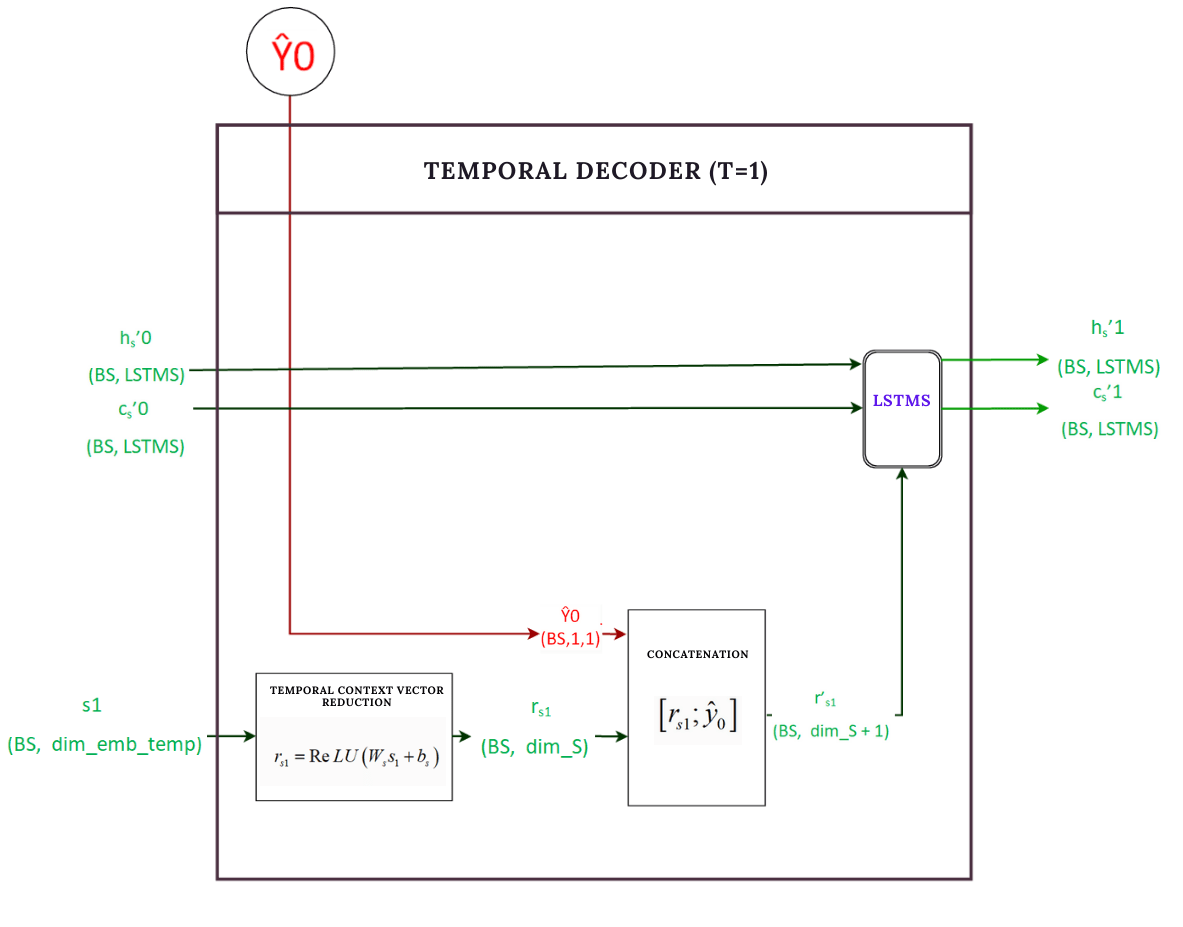

In [27]:
class TemporalDecoder(tf.keras.layers.Layer):
    def __init__(self, dim_LSTMS,dim_S,regul,drop):
        self.drop = drop
        self.regul = regul
        self.dim_LSTMS = dim_LSTMS          # Dimension of the hidden states
        self.dim_S = dim_S                  # Reduced dimension of the Temporal context vector
        super().__init__()
        
    def build(self,input_shape):
        self.TemporalReducedLayer = tf.keras.layers.Dense(units=self.dim_S,activation="relu")
        self.LayerLSTMS = tf.keras.layers.LSTM(units=self.dim_LSTMS,return_state=True, kernel_regularizer=tf.keras.regularizers.l2(self.regul),
                                            dropout=self.drop,recurrent_dropout=self.drop,name="LSTM_TemporalDecoder")
        super().build(input_shape) 
        
    # Inputs :
    # vc_tempo : Temporal Context Vector: (BS,dim_emb_temp)
    # hid_state_1 : Hidden state of the Temporal Decoder (t-1) : (BS,LSTMS)
    # cell_state_1 : Cell state of the Temporal Decoder (t-1)  : (BS,LSTMS)
    # y_pred_0 :  Prediction (t-1) : (BS,1,1)
    
    # Outputs :
    # hid_state : Hidden state of the Temporal Decoder (t): (BS,LSTMS)
    # cell_state : Cell state of the Temporal Decoder (t) : (BS,LSTMS)
    
    def call(self, vc_tempo,hid_state_1,cell_state_1,y_pred_0):
        # Reduction of the Temporal Context Vector
        rs = self.TemporalReducedLayer(vc_tempo)  # (BS,dim_S)
        
        # Concatenation of the reduced vector with the prediction at (t-1)
        rs = tf.concat([rs,tf.squeeze(y_pred_0,-1)],axis=1) # (BS,dim_S + 1)
        rs = tf.expand_dims(rs,-1)                          # (BS,dim_S + 1,1)
        
        # Applying LSTMS
        out_dec, hid_state, cell_state = self.LayerLSTMS(rs,initial_state=[hid_state_1,cell_state_1])
        return hid_state,cell_state
    

#### **7. Putting all together and creating the final layer that generates predictions**

**Note**:  
First, I depicted the **final layer** that generates predictions

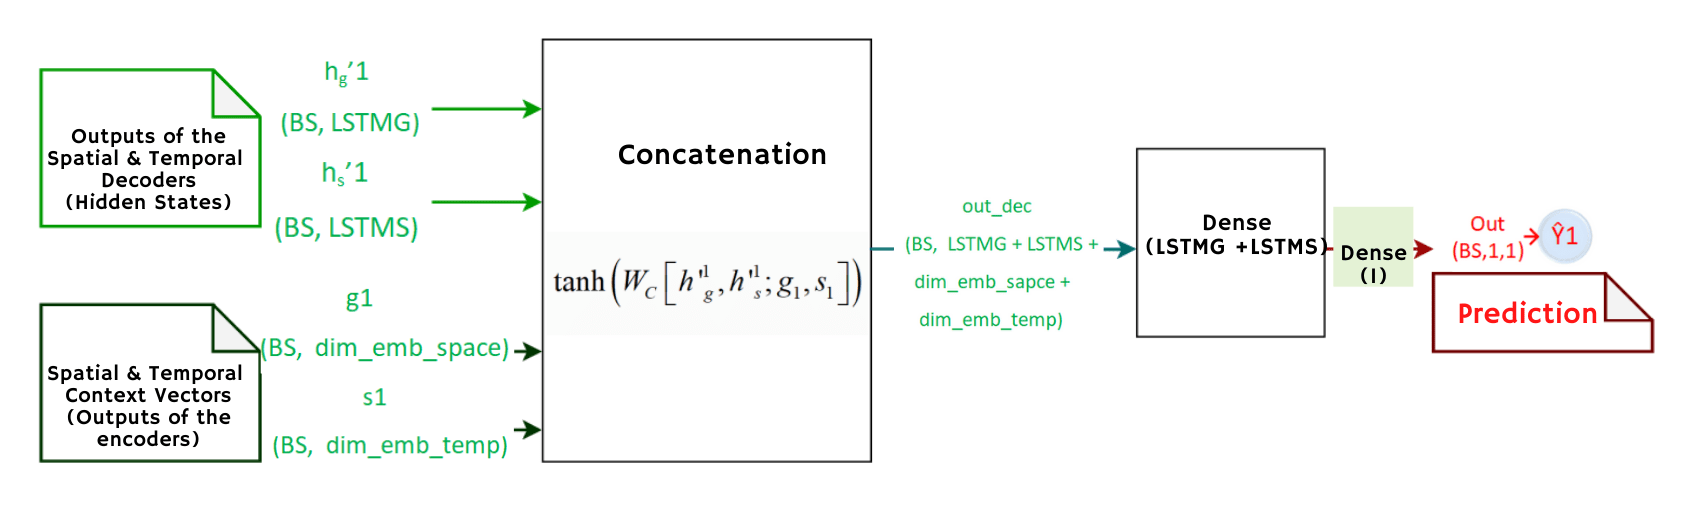

**Note:**  
Second,I've given a **complete view** of **all the model's layers** below (that I developed above)
- Spatial Encoder (t=1) & Spatial Decoder (t=1)
- Temporal Encoder (t=1) & Temporal Encoder (t=1)
- The prediction is generated by the **Final Layer**, which receives the **Spatial & Temporal hidden states** as well as the **Spatial & Temporal context vectors**.

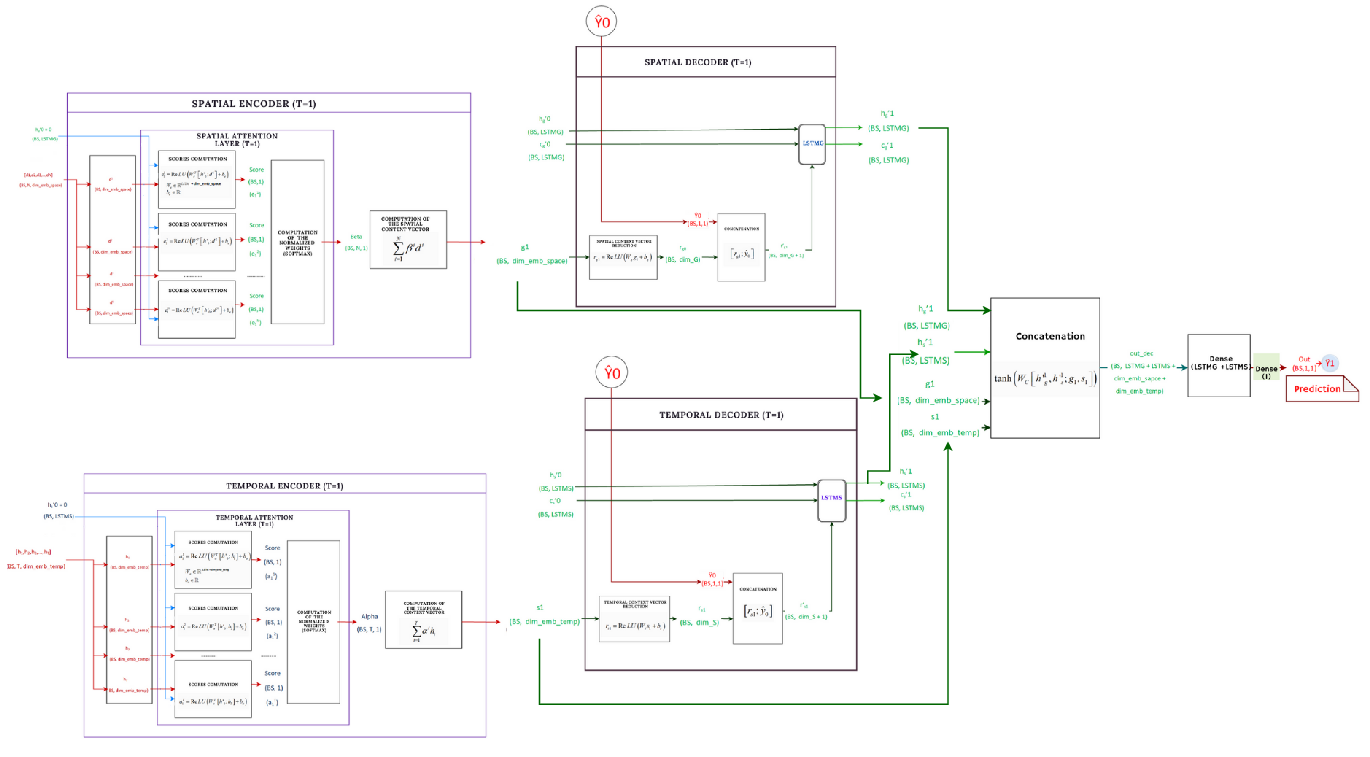

In [28]:
# For more details about the Final_STAM class, see illustrations above

class Final_STAM(tf.keras.layers.Layer):
    def __init__(self,creationspatialembeddings, creationtemporalembeddings, spatialencoder, temporalencoder,
               spatialdecoder,temporaldecoder,len_seq, len_out, regul, drop,dim_LSTMG,dim_LSTMS):
        self.creationspatialembeddings = creationspatialembeddings
        self.creationtemporalembeddings = creationtemporalembeddings
        self.spatialencoder = spatialencoder
        self.temporalencoder = temporalencoder
        self.spatialdecoder = spatialdecoder
        self.temporaldecoder = temporaldecoder
        self.len_seq = len_seq
        self.len_out = len_out
        self.regul = regul
        self.drop = drop
        self.dim_LSTMG = dim_LSTMG
        self.dim_LSTMS = dim_LSTMS
        super().__init__()
        
    def build(self,input_shape):
        self.FirstLayerDense = tf.keras.layers.Dense(units=self.dim_LSTMG+self.dim_LSTMS,activation="tanh")
        self.LayerPrediction = tf.keras.layers.Dense(units=1)
        super().build(input_shape)
    
    # Inputs :
    # input:  Exegonous series : (BS,Tx,N-1)
    # target: Target series    : (BS,Tx,1)
    
    # Outputs :
    # outputs : Prédiction(s) Y : (BS,len_out,1)
    
    def call(self,input,target):
        # Creation of spatial embeddings
        spatial_embdgs = self.creationspatialembeddings(tf.concat([input,target],axis=-1))  #(BS,N,dim_emb_space) 
        temporal_embdgs = self.creationtemporalembeddings(tf.concat([input,target],axis=-1))#(BS,N,dim_emb_temp)
        
        # Initialize hidden_states and cells_states
        hid_state_spatial_1 = tf.matmul(input[:,0:1,0:1],tf.zeros(shape=(1,self.dim_LSTMG))) #(BS,1,1)x(1,dim_LSTMG) 
                                                                                             #(BS,1,dim_LSTMG)
        hid_state_spatial_1 = tf.transpose(hid_state_spatial_1,perm=[0,2,1])  #(BS,dim_LSTMG,1)
        hid_state_spatial_1 = tf.squeeze(hid_state_spatial_1,-1)              #(BS,dim_LSTMG)
        cell_state_spatial_1 = hid_state_spatial_1
        
        hid_state_temporal_1 = tf.matmul(input[:,0:1,0:1],tf.zeros(shape=(1,self.dim_LSTMS)))  #(BS,1,1)x(1,dim_LSTMS)
                                                                                               #(BS,1,dim_LSTMS)
        hid_state_temporal_1 = tf.transpose(hid_state_temporal_1,perm=[0,2,1])   #(BS,dim_LSTMS,1)
        hid_state_temporal_1 = tf.squeeze(hid_state_temporal_1,-1)               #(BS,dim_LSTMS)
        cell_state_temporal_1 = hid_state_temporal_1
        
        # Initialize the prédiction at t=0 
        y_pred_0 = tf.matmul(target[:,0:1,:],tf.zeros(shape=(1,1)))   #(BS,1,1)x(1,1) = (BS,1,1)
        
        outputs = []
        for t in range(self.len_out):
            # Computation of the spatial & temporal context vectors
            g = self.spatialencoder(spatial_embdgs,hid_state_spatial_1)       # (BS,dim_emb_space)
            s = self.temporalencoder(temporal_embdgs,hid_state_temporal_1)    # (BS,dim_emb_temp)
            
            # Spatial & Temporal Decoders
            hid_state_dec_spatial,cell_state_dec_spatial = self.spatialdecoder(
                g,hid_state_spatial_1,cell_state_spatial_1,y_pred_0)          #(BS,dim_LSTMG)
            hid_state_dec_temporal,cell_state_dec_temporal = self.temporaldecoder(
                s,hid_state_temporal_1,cell_state_temporal_1,y_pred_0)        #(BS,dim_LSTMS)
            
            # Concatenation of the hidden states & context vectors
            out_dec = tf.concat([hid_state_dec_spatial,hid_state_dec_temporal,g,s],axis=1)
            # out_dec: (BS, dim_LSTMG + dim_LSTMS+ dim_emb_space+ dim_emb_tempo)
            
            y_pred_1 = self.FirstLayerDense(out_dec)       #(BS,dim_LSTMG+dim_LSTMS)
            y_pred_1 = self.LayerPrediction(y_pred_1)      #(BS,1)
            y_pred_1 = tf.expand_dims(y_pred_1,-1)         #(BS,1,1)
            
            outputs.append(y_pred_1)
            
            # The new values of the hidden states & cell states (fot the next time step in len_out)
            hid_state_spatial_1 = hid_state_dec_spatial
            cell_state_spatial_1 = cell_state_dec_spatial
            hid_state_temporel_1 = hid_state_dec_temporal
            cell_state_temporel_1 = cell_state_dec_temporal
        outputs = tf.convert_to_tensor(outputs)         # (len_out,BS,1,1)
        outputs = tf.squeeze(outputs,-1)                # (len_out,BS,1)
        outputs = tf.transpose(outputs,perm=[1,0,2])    # (BS,len_out,1)
        return outputs
        

<a id="section-seven"></a>
# **VII- Creation of the Model:**

In [29]:
dim_space = 128
dim_temp = 128

dim_LSTMG = 128
dim_LSTMS = 128
dim_G = 128 # I used basic value/ But because this param is designed to be a reduction of dim_LSTMG, you can experiment with it to see how the performance changes. 
dim_S = 128 # I used basic value/ But because this param is designed to be a reduction of dim_LSTMS, you can experiment with it to see how the performance changes. 
drop=0.0
l2reg=0.0

def get_stam_model():
    
    inputs_exogenous = tf.keras.layers.Input(shape=(len_seq,x_train[0].shape[2]))
    input_target = tf.keras.layers.Input(shape=(len_seq,1))
    
    creationspatialembeddings = CreationSpatialEmbeddings(dim_emb_space = dim_space)
    creationtemporalembeddings = CreationTemporalEmbeddings(dim_emb_temp= dim_temp)
    spatialencoder = SpatialAttention_SpatialEncoder()
    temporalencoder = TemporalAttention_TemporalEncoder()
    spatialdecoder = SpatialDecoder(dim_LSTMG=dim_LSTMG,dim_G=dim_G,regul=l2reg,drop=drop)
    temporaldecoder = TemporalDecoder(dim_LSTMS=dim_LSTMS,dim_S=dim_S,regul=l2reg,drop=drop)
    
    output = Final_STAM(creationspatialembeddings,creationtemporalembeddings,spatialencoder,temporalencoder,
                      spatialdecoder,temporaldecoder,len_seq,len_out,
                      l2reg,drop,dim_LSTMG,dim_LSTMS)(inputs_exogenous,input_target)
    
    model = tf.keras.Model([inputs_exogenous,input_target],output)
    return model
    

<a id="section-eight"></a>
# **VIII- Train the Model with TPU:**

In [30]:
# detect and initialize the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
print("All devices: ", tf.config.list_logical_devices('TPU'))

2022-05-04 09:23:18.384450: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-04 09:23:18.404630: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-05-04 09:23:18.404685: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2022-05-04 09:23:18.419363: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-05-04 09:23:18.419418: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2022-05-04 09:23:18.419979: I tensorflow/core/distributed_runtime/rpc/grpc_server_lib.cc:411] Started server with target: grpc://localhost:30019


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


In [31]:
max_periods = 500
# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    #creation of the model 
    model = get_stam_model()
    
    # Definition of the parameters related to the evolution of the learning rate
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      initial_learning_rate=0.001,
      decay_steps=50,
      decay_rate=0.01)
    
    optimiseur=tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    
    # Using ModelCheckPoint
    CheckPoint = tf.keras.callbacks.ModelCheckpoint("weights_train.hdf5", monitor='loss', verbose=1,
                                                  save_best_only=True, save_weights_only = True, mode='auto',
                                                  save_freq='epoch')
    # Compile the model
    model.compile(loss="mse", optimizer=optimiseur)
    
    # train the model
    history = model.fit(x=[x_train[0],x_train[1]],y=y_train,validation_data=([x_val[0],x_val[1]],y_val),
                      epochs=max_periods,verbose=1, 
                      callbacks=[CheckPoint,tf.keras.callbacks.EarlyStopping(monitor='loss', patience=60)],
                      batch_size=batch_size)
    
    
    

Epoch 1/500
17/17 [==============================] - 17s 205ms/step - loss: 0.1043 - val_loss: 0.0093

Epoch 00001: loss improved from inf to 0.05272, saving model to weights_train.hdf5
Epoch 2/500
17/17 [==============================] - 1s 47ms/step - loss: 0.0069 - val_loss: 0.0026

Epoch 00002: loss improved from 0.05272 to 0.00550, saving model to weights_train.hdf5
Epoch 3/500
17/17 [==============================] - 1s 48ms/step - loss: 0.0029 - val_loss: 0.0020

Epoch 00003: loss improved from 0.00550 to 0.00271, saving model to weights_train.hdf5
Epoch 4/500
17/17 [==============================] - 1s 52ms/step - loss: 0.0019 - val_loss: 0.0011

Epoch 00004: loss improved from 0.00271 to 0.00188, saving model to weights_train.hdf5
Epoch 5/500
17/17 [==============================] - 1s 49ms/step - loss: 0.0016 - val_loss: 9.1549e-04

Epoch 00005: loss improved from 0.00188 to 0.00152, saving model to weights_train.hdf5
Epoch 6/500
17/17 [==============================] - 1s 47

Text(0.5, 1.0, 'Evolution of the loss')

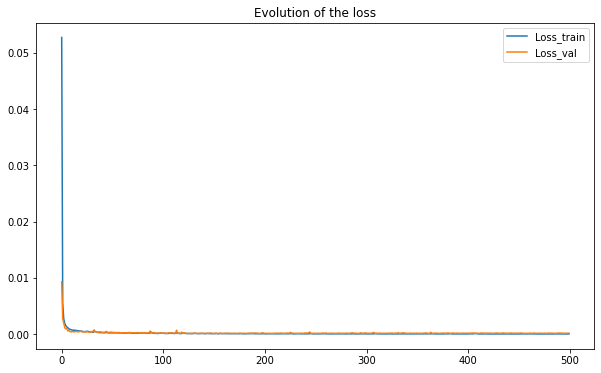

In [32]:
# The evolution of loss during the training
loss_train = history.history["loss"]
loss_val = history.history["val_loss"]

plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(loss_train)),loss_train, label="Loss_train")
plt.plot(np.arange(0,len(loss_train)),loss_val, label ="Loss_val")
plt.legend()

plt.title("Evolution of the loss")

<a id="section-nine"></a>
# **VIV- Predictions using the trained STAM Model:**

In [33]:
# I saved the best weights on the Kaggle/Output by using the ModelCheckPoint callback during the training phase.
model = get_stam_model()
model.load_weights("./weights_train.hdf5")

In [34]:
pred_train = model.predict([x_train[0],x_train[1]],verbose=1)
pred_val = model.predict([x_val[0],x_val[1]],verbose=1)

16/16 [==============================] - 1s 53ms/step


- **Visualizations**

In [35]:
import plotly.graph_objects as go

shift = 1
fig = go.FigureWidget()

# Original series of 'Indoor_Temperature_room'
fig.add_trace(go.Scatter(x=df.index,y=train_x_norm [:,-1],line = {'color':'blue', 'width':1}, name= 'real_temperature_train'))
fig.add_trace(go.Scatter(x=df.index[splitting_time:],y=val_x_norm[:,-1],line = {'color':'red', 'width':1}, name = 'real_temperature_val' ))

# Dislply the predictions (for the train dataset)
preds = []

max = len(pred_train)
max = max
for i in range(0,max):
  preds.append(tf.squeeze(pred_train[i,0:shift,:],1))
preds = tf.convert_to_tensor(preds).numpy()
preds = np.reshape(preds,(preds.shape[0]*preds.shape[1]))

fig.add_trace(go.Scatter(x=df.index[len_seq:],y=preds, mode='lines', line={'color':'yellow', 'width':1}, name = 'predictions_train'))

# Dislply the predictions (for the validation dataset)
predsv = []
max2 = len(pred_val)

for i in range(0,max2):
  predsv.append(tf.squeeze(pred_val[i,0:shift,:],1))

predsv = tf.convert_to_tensor(predsv).numpy()
predsv = np.reshape(predsv,(predsv.shape[0]*predsv.shape[1]))

fig.add_trace(go.Scatter(x=df.index[splitting_time+len_seq:],y=predsv, mode='lines', line={'color':'green', 'width':1}, name = 'predictions_val'))

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

<a id="section-ten"></a>
# **VV- MSE Computation on the unscaled data:**

- **Training dataset**

In [36]:
train_x_norm_2 = train_x_norm[len_seq:-(train_x_norm[len_seq:,:].shape[0]-preds.shape[0]),:]
train_x_norm_2_s = scaler.inverse_transform(train_x_norm_2)

temp_real = train_x_norm_2_s[:,-1]
temp_real

array([23.43600082, 23.66799927, 23.85199928, ..., 17.45669937,
       17.51530075, 17.67869949])

In [37]:
train_x_norm_preds = train_x_norm_2.copy()
train_x_norm_preds[:,-1] = preds
train_x_norm_preds_s = scaler.inverse_transform(train_x_norm_preds)

temp_preds = train_x_norm_preds_s[:,-1]
temp_preds

array([23.38800951, 23.60176838, 23.83455717, ..., 17.46850631,
       17.56359723, 17.7010277 ])

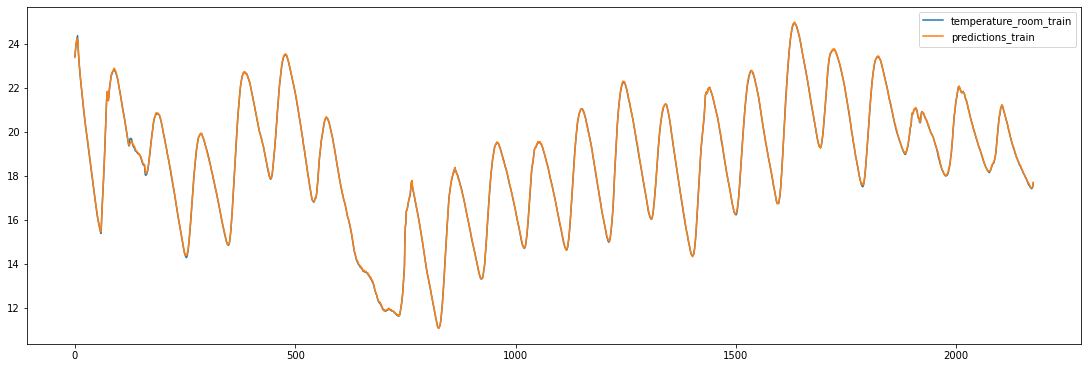

In [38]:
df_2 = pd.DataFrame({'temperature_room_train':temp_real,'predictions_train':temp_preds})

fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))
for i in range(2):
  ax.plot(df_2.index.values,df_2.values[:,i], label= list(df_2.columns)[i])
ax.legend()
plt.show()

In [39]:
# Compute the MSE on the training dataset
mse_train = tf.keras.losses.mse(temp_real,temp_preds)
print( f"MSE on the train dataset is: {mse_train.numpy()}")

MSE on the train dataset is: 0.001369983029908209


- **Validation dataset**

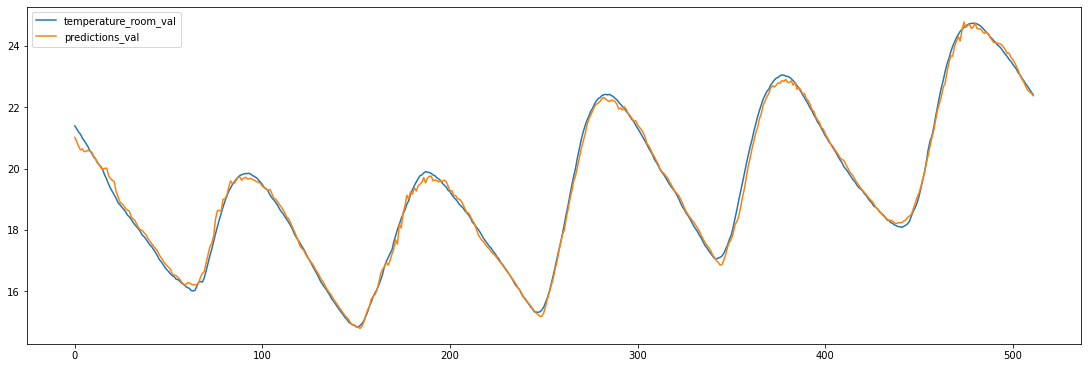

In [40]:
val_x_norm_2 = val_x_norm[len_seq:-(val_x_norm[len_seq:,:].shape[0]-predsv.shape[0]),:]
val_x_norm_2_s = scaler.inverse_transform(val_x_norm_2)
real_temp_v = val_x_norm_2_s[:,-1]

val_x_norm_preds = val_x_norm_2.copy()
val_x_norm_preds[:,-1] = predsv

val_x_norm_preds_s = scaler.inverse_transform(val_x_norm_preds)

preds_temp_v = val_x_norm_preds_s[:,-1]

df_3 = pd.DataFrame({'temperature_room_val':real_temp_v,'predictions_val':preds_temp_v})


fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))
for i in range(2):
  ax.plot(df_3.index.values,df_3.values[:,i], label= list(df_3.columns)[i])
ax.legend()
plt.show()

In [41]:
# Compute the MSE on the validation dataset
mse_val = tf.keras.losses.mse(real_temp_v,preds_temp_v)
print( f"MSE on the validation dataset is: {mse_val.numpy()}")

MSE on the validation dataset is: 0.024202559143304825


<a id="section-eleven"></a>
# **VVI- Discussion and Suggestions for using STAM Model on the competition's test dataset:**


- By using the **STAM Model**, the fit is **flawless** on the **validation dataset** (comparing it to this Random Forest model that I developed as a starter notebook to discuss the **expected Magnitude order of the Scoring Metric** [here](https://www.kaggle.com/code/abireltaief/starter-magnitude-order-of-the-scoring-metric).

- I used a **single step prediction** method (that means the length of the output **len_out = 1**:  YT+1), but you can experiment with **multiple step prediction** (and it's simple to do because all you have to do is **change** my **len_out** parameter, since the datasets creation (choose a value other than 1, for example 5, 6, 10 and so on) and follow the same steps I did; you'll notice that **the STAM Model's performance remains high** on the validation dataset even with multiple step prediction.

- However, as you know from the [arxiv_paper](https://arxiv.org/pdf/2008.04882.pdf), the STAM model is a **causal model** that uses exogenous series as well as the target's **past data** to forecast the future. **The difficulty now** is how to use it for **inference** (on the test dataset, when we have not the target values **?** (especially that the test dataset is already separated from the train dataset by several days)

- The **Answer** to the question above is : Now that you have the whole STAM model implemented and trained using the train competition dataset, all you have to do is to **train the STAM model** exclusively on the **exogenous series** to **predict the target**: You **force** the model to **learn only from exogenous series**. But you'll need to adapt the structure of the datasets by changing the **prepare_dataset_XY** function (which I'll show you below) and you'll need to change a few lines in the STAM model classes (I mean **the class that uses the target**) and don't forget to change the **y_pred_0 initialization** (...)) and, of course, no longer use a tuple **[x[0], x[1]]** in the model inputs (instead, use exogenous series: **x**). I also propose **adjusting** the **dim_G** and **dim_S** hyperparameters (to reduce LSTMG and LSTMS), as well as **l2reg** and **drop** hyperparameters(...) and you'll be very good to go!


In [42]:
# I give a suggestion for the modified prepare_dataset_XY, to train the model exclusively on the exogenous series.
def prepare_dataset_XY_modif(seriesx, seriesy, len_seq, len_out, batch_size,shift):
  '''
  A function for creating a tf.dataset from time series data as follows:
  dataset : {X,Y}
  X = {((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),(X3_1,X3_2,...,X3_T)),
       (Y1,Y2,...,YT)}
  Y = YT+1
  seriesx-- Exogenous series, shape: (Tin, number_of_exogenous_series) with Tin: length of the time series
  seriesy-- Target series, shape: (Tin, 1)
  len_seq-- Sequence length: integer
  len_out-- Length of the predicted sequence (output): integer
  shift-- The window offset: integer
  batch_size-- Size of the batch: integer

  '''
  # Exogenous series
  # ((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),(X3_1,X3_2,...,X3_T),....)
  dataset_x = tf.data.Dataset.from_tensor_slices(seriesx)
  dataset_x = dataset_x.window(len_seq+len_out, shift = shift, drop_remainder=True)
  dataset_x = dataset_x.flat_map(lambda x: x.batch(len_seq+len_out))
  dataset_x = dataset_x.map(lambda x: x[0:len_seq][:,:]) # shape:[[ ]]
  dataset_x = dataset_x.batch(batch_size, drop_remainder=True).prefetch(1) # shape: [[[]]] (adding the batch_size)

  # The target series (I keep this to extract the YT+1, but I will not return it)
  # (Y1,Y2,...,YT)
  dataset_y = tf.data.Dataset.from_tensor_slices(seriesy)
  dataset_y = dataset_y.window(len_seq+len_out, shift = shift, drop_remainder=True)
  dataset_y = dataset_y.flat_map(lambda x: x.batch(len_seq+len_out))
  dataset_y = dataset_y.map(lambda x: x[0:len_seq][:,:]) 
  dataset_y = dataset_y.batch(batch_size, drop_remainder=True).prefetch(1)

  # Y = YT+1 (the values to predict)
  dataset_ypred = tf.data.Dataset.from_tensor_slices(seriesy)
  dataset_ypred = dataset_ypred.window(len_seq+len_out+1, shift=shift, drop_remainder=True)
  dataset_ypred = dataset_ypred.flat_map(lambda x: x.batch(len_seq+len_out+1))
  dataset_ypred = dataset_ypred.map(lambda x: (x[0:len_seq+1][-len_out:,:]))
  dataset_ypred = dataset_ypred.batch(batch_size, drop_remainder=True).prefetch(1)
  
  # Here the main modification
  dataset = tf.data.Dataset.zip((dataset_x, dataset_ypred))
  return dataset

In [43]:
# A practical example of the modification
X1 = np.linspace(1,100,100) # 3 exogenous series
X2 = np.linspace(101,200,100)
X3 = np.linspace(201,300,100)
Y = np.linspace(301,400,100) # target series

X1 = tf.expand_dims(X1,-1)
X2 = tf.expand_dims(X2,-1)
X3 = tf.expand_dims(X3,-1)
Y = tf.expand_dims(Y,-1)

series_x = tf.concat([X1,X2,X3], axis=1)
series_y = Y

len_seq = 10
len_out = 1
shift = 1
batch_size = 1

dataset_example = prepare_dataset_XY_modif(series_x, series_y, len_seq, len_out, batch_size,shift)

In [44]:
# As you can see: the function no longer returns the target series
for element in dataset_example.take(1):
  print("Exogenous series: ")
  print(element[0])
  print("======================")
  print("Value to predict: ")
  print(element[1])

Exogenous series: 
tf.Tensor(
[[[  1. 101. 201.]
  [  2. 102. 202.]
  [  3. 103. 203.]
  [  4. 104. 204.]
  [  5. 105. 205.]
  [  6. 106. 206.]
  [  7. 107. 207.]
  [  8. 108. 208.]
  [  9. 109. 209.]
  [ 10. 110. 210.]]], shape=(1, 10, 3), dtype=float64)
Value to predict: 
tf.Tensor([[[311.]]], shape=(1, 1, 1), dtype=float64)


2022-05-04 09:31:39.042695: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 193731, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1651656699.039113903","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 193731, Output num: 0","grpc_status":3}


<a id="section-twelve"></a>
# **References:**
- Keras.io: [keras.io](https://keras.io/)
- TensorFlow Learn: [TFLearn](https://www.tensorflow.org/learn)
- Spatiotemporal Attention for Multivariate Time Series paper: [STAM Paper](https://arxiv.org/abs/2008.04882)
- How To use TPU? : [kaggle documentation](https://www.kaggle.com/docs/tpu)